# Clustering segments
This notebook experiments with various levels of "clustering" based on the precision of latitude/longitude

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# import add_segment_id_column
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle

## Get the lion segments data

In [4]:
import geopandas as gpd

In [7]:
GDB_FILE = r"output/filtered-lion.gdb"

lion_gdf = gpd.read_file(GDB_FILE, engine='pyogrio')
lion_gdf['SegmentID'].unique().size

11606

## 1. 311 Data
We will start with 311 noise complaints as they have the most coverage geoegraphically

In [5]:
SERVICE_311_DATA = "input_data/311_Service_Requests_2024_Noise.csv"
df = pd.read_csv(SERVICE_311_DATA)
df.head()

/var/folders/k2/s9j0wvg542n0d4_0n5lwnp140000gn/T/ipykernel_37909/3298517107.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SERVICE_311_DATA)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,Police Precinct
0,59896272,01/01/2024 12:00:00 AM,01/02/2024 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211.0,145 GRAND STREET EXTENSION,...,NaN,40.710675,-73.954050,"(40.710675306389646, -73.954050047883)",17613.0,36.0,2.0,30.0,56.0,56.0
1,59898042,01/01/2024 12:00:00 AM,01/02/2024 09:24:45 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10462.0,711 MORRIS PARK AVENUE,...,NaN,40.845340,-73.865594,"(40.84533975748463, -73.86559379953668)",11271.0,59.0,5.0,22.0,32.0,32.0
2,59894610,01/01/2024 12:00:00 AM,01/02/2024 09:46:32 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304.0,7 NAVY PIER COURT,...,NaN,40.628828,-74.074387,"(40.628827651071944, -74.0743866176229)",10691.0,4.0,1.0,13.0,74.0,74.0
3,59899838,01/01/2024 12:00:00 AM,01/02/2024 09:42:25 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022.0,1069 1 AVENUE,...,NaN,40.759192,-73.962290,"(40.759191822016476, -73.96228991313669)",12419.0,71.0,4.0,1.0,9.0,9.0
4,59887043,01/01/2024 12:00:20 AM,01/01/2024 12:41:01 AM,NYPD,New York City Police Department,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,...,NaN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)",13511.0,10.0,2.0,44.0,41.0,41.0


In [6]:
df_complaints = df[["Created Date", "Complaint Type", "Descriptor", "Incident Address", "Address Type", "Borough", "Latitude", "Longitude", "Location Type"]]
df_complaints = df_complaints[df["Borough"] == "MANHATTAN"]
df_complaints = df_complaints[df_complaints['Complaint Type'].str.contains("Noise|Loud")]
df_complaints = df_complaints[df_complaints["Complaint Type"] != "Noise - Residential"]

In [7]:
complaints_csv = f"output/noise-complaints-no-segments.csv"
df_complaints.to_csv(complaints_csv, index=False)
print(f"Complaints saved: {complaints_csv}")

Complaints saved: output/noise-complaints-no-segments.csv


## Test different precision levels

In [8]:
# ~	78.7 mm	
precision_6 = pd.DataFrame(df_complaints)
precision_6['Latitude'] = precision_6['Latitude'].round(6)
precision_6['Longitude'] = precision_6['Longitude'].round(6)
print(f"Precision 6: {precision_6[['Latitude', 'Longitude']].drop_duplicates().size} unique lat/longs")

# ~0.787 m
precision_5 = pd.DataFrame(df_complaints)
precision_5['Latitude'] = precision_5['Latitude'].round(5)
precision_5['Longitude'] = precision_5['Longitude'].round(5)
print(f"Precision 5: {precision_5[['Latitude', 'Longitude']].drop_duplicates().size} unique lat/longs")


# ~7.87 m
precision_4 = pd.DataFrame(df_complaints)
precision_4['Latitude'] = precision_4['Latitude'].round(4)
precision_4['Longitude'] = precision_4['Longitude'].round(4)
print(f"Precision 4: {precision_4[['Latitude', 'Longitude']].drop_duplicates().size} unique lat/longs")

# ~78.7 m
precision_3 = pd.DataFrame(df_complaints)
precision_3['Latitude'] = precision_3['Latitude'].round(3)
precision_3['Longitude'] = precision_3['Longitude'].round(3)
print(f"Precision 3 {precision_3[['Latitude', 'Longitude']].drop_duplicates().size} unique lat/longs")

# ~	0.787 km
precision_2 = pd.DataFrame(df_complaints)
precision_2['Latitude'] = precision_2['Latitude'].round(2)
precision_2['Longitude'] = precision_2['Longitude'].round(2)
print(f"Precision 2 {precision_2[['Latitude', 'Longitude']].drop_duplicates().size} unique lat/longs")


Precision 6: 26554 unique lat/longs
Precision 5: 26554 unique lat/longs
Precision 4: 22512 unique lat/longs
Precision 3 7426 unique lat/longs
Precision 2 174 unique lat/longs


Precision 3 and 4 look most promising - lets see how much of a difference it makes in our segment counts

In [9]:
add_segment_id_column.add_segment_id_column(precision_4)
add_segment_id_column.add_segment_id_column(precision_3)

Completed 14000 rows
Rows left: 37344
Completed 17000 rows
Rows left: 36615
Completed 27000 rows
Rows left: 35139
Completed 48000 rows
Rows left: 32302
Completed 78000 rows
Rows left: 30207
Completed 101000 rows
Rows left: 28681
Completed 110000 rows
Rows left: 27702
Completed 113000 rows
Rows left: 27193
Completed 121000 rows
Rows left: 26759
Completed 125000 rows
Rows left: 26480
Completed 248000 rows
Rows left: 21750
Completed 249000 rows
Rows left: 21596
Completed 313000 rows
Rows left: 19086
Completed 314000 rows
Rows left: 18988
Completed 339000 rows
Rows left: 17933
Completed 348000 rows
Rows left: 17651
Completed 357000 rows
Rows left: 17333
Completed 379000 rows
Rows left: 16316
Completed 382000 rows
Rows left: 16104
Completed 389000 rows
Rows left: 15989
Completed 404000 rows
Rows left: 15687
Completed 414000 rows
Rows left: 15542
Completed 429000 rows
Rows left: 15150
Completed 486000 rows
Rows left: 13736
Completed 528000 rows
Rows left: 12834
Completed 535000 rows
Rows lef

In [11]:
precision_4['SegmentId'].unique().size

5262

In [12]:
precision_3['SegmentId'].unique().size

3310

In [13]:
precision_3_csv = f"output/noise-complaints-segments-p3.csv"
precision_3.to_csv(precision_3_csv, index=False)
print(f"Complaints saved: {precision_3_csv}")

Complaints saved: output/noise-complaints-segments-p3.csv


In [14]:
precision_4_csv = f"output/noise-complaints-segments-p4.csv"
precision_4.to_csv(precision_4_csv, index=False)
print(f"Complaints saved: {precision_4_csv}")

Complaints saved: output/noise-complaints-segments-p4.csv


In [154]:
precision_3 = pd.read_csv("output/noise-complaints-segments-p3.csv")
precision_4 = pd.read_csv("output/noise-complaints-segments-p4.csv")

In [153]:
def generate_columns(df):
    df['Created Date'] = pd.to_datetime(df['Created Date'])
    df['Timestamp_Rounded'] = df['Created Date'].dt.round("h")
    df['SegmentId'] = df['SegmentId'].transform(lambda x: str(x)[:-2].rjust(7, "0"))
    df['SegmentId'] = df['SegmentId'].astype('category')
    df['Timestamp'] = df['Timestamp_Rounded']
    df['Month'] = df['Timestamp_Rounded'].dt.month
    df['DayOfMonth'] = df['Timestamp_Rounded'].dt.day
    df['DayOfWeek'] = df['Timestamp_Rounded'].dt.dayofweek
    df['Hour'] = df['Timestamp_Rounded'].dt.hour

In [155]:
def clip_counts(df):
    df['Count'] = df['Count'].clip(upper=5)

In [156]:
precision_3 = precision_3.drop_duplicates()
precision_4 = precision_4.drop_duplicates()

In [157]:
generate_columns(precision_3)
generate_columns(precision_4)

In [158]:
precision_3['SegmentId'].value_counts()

SegmentId
0037188    1770
9006647    1004
0037084     906
0294153     594
0038680     572
           ... 
0072649       1
0023201       1
0305535       1
0072478       1
9023763       1
Name: count, Length: 3310, dtype: int64

In [159]:
precision_3_counts = precision_3.groupby(['Timestamp_Rounded', 'SegmentId']).size().reset_index(name='Count')
precision_4_counts = precision_4.groupby(['Timestamp_Rounded', 'SegmentId']).size().reset_index(name='Count')

### Adjust our counts into a reasonable range

In [160]:
clip_counts(precision_3_counts)
clip_counts(precision_4_counts)

In [161]:
precision_3_counts['Count'].value_counts()

Count
0    11604737
1       30904
2        3700
3        1005
5         488
4         436
Name: count, dtype: int64

In [162]:
precision_4_counts['Count'].value_counts()

Count
0    18469106
1       31936
2        3671
3         953
5         419
4         369
Name: count, dtype: int64

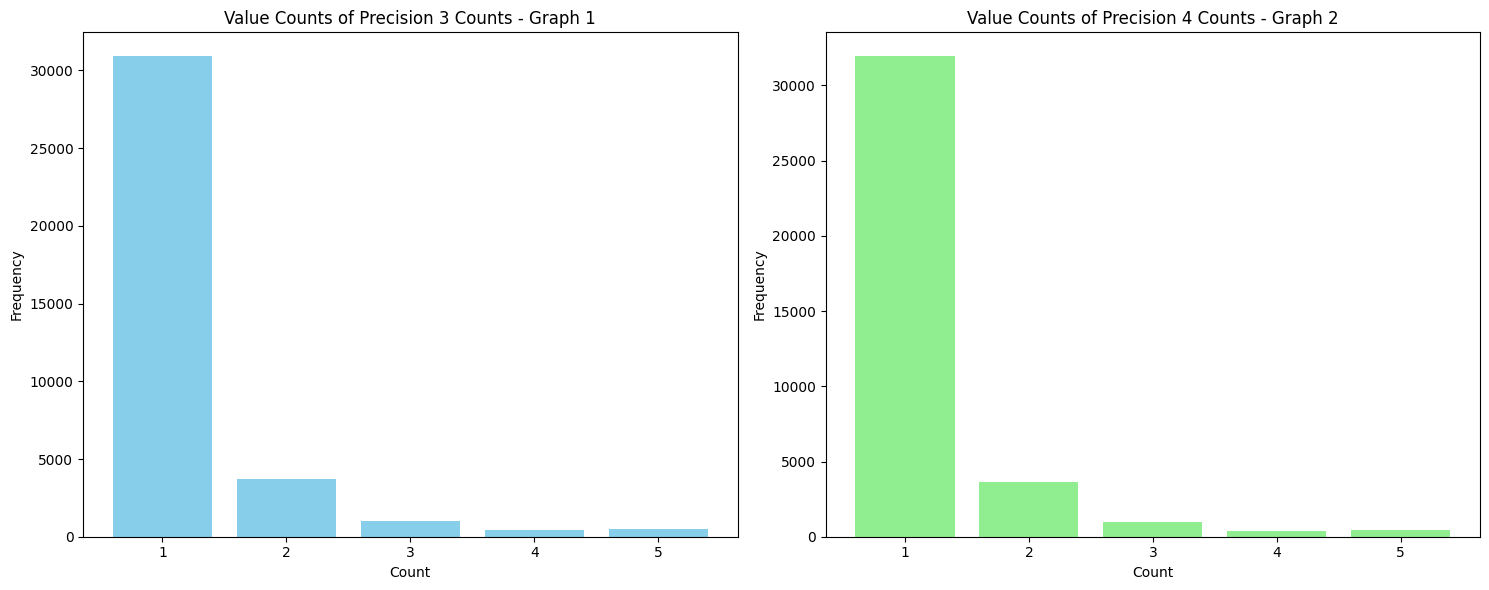

In [163]:
precision_3_counts_over_0 = precision_3_counts[precision_3_counts['Count'] > 0]['Count'].value_counts()
precision_4_counts_over_0 = precision_4_counts[precision_4_counts['Count'] > 0]['Count'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first graph
axes[0].bar(precision_3_counts_over_0.index, precision_3_counts_over_0.values, color='skyblue')
axes[0].set_title('Value Counts of Precision 3 Counts - Graph 1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(precision_3_counts_over_0.index)

# Plot the second graph
axes[1].bar(precision_4_counts_over_0.index, precision_4_counts_over_0.values, color='lightgreen')
axes[1].set_title('Value Counts of Precision 4 Counts - Graph 2')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(precision_4_counts_over_0.index)

# Display the plots
plt.tight_layout()
plt.show()

Findings: there isn't much of a difference between precision 4 and precision 3 so let's use precision 4 since it has more segment coverage

## Test different groupings

In [164]:
df = precision_4

In [165]:
by_timestamp = precision_4.groupby(['Timestamp_Rounded', 'SegmentId']).size().reset_index(name='Count')
by_hour_only = precision_4.groupby(['Hour', 'SegmentId']).size().reset_index(name='Count')
by_day_and_hour = precision_4.groupby(['Hour', 'DayOfWeek', 'SegmentId']).size().reset_index(name='Count')

In [166]:
clip_counts(by_hour_only)
clip_counts(by_day_and_hour)

In [167]:
by_hour_only['Count'].value_counts()

Count
0    106631
1     12965
2      3208
5      1559
3      1262
4       663
Name: count, dtype: int64

In [168]:
by_day_and_hour['Count'].value_counts()

Count
0    855392
1     21845
2      3686
5      1311
3      1186
4       596
Name: count, dtype: int64

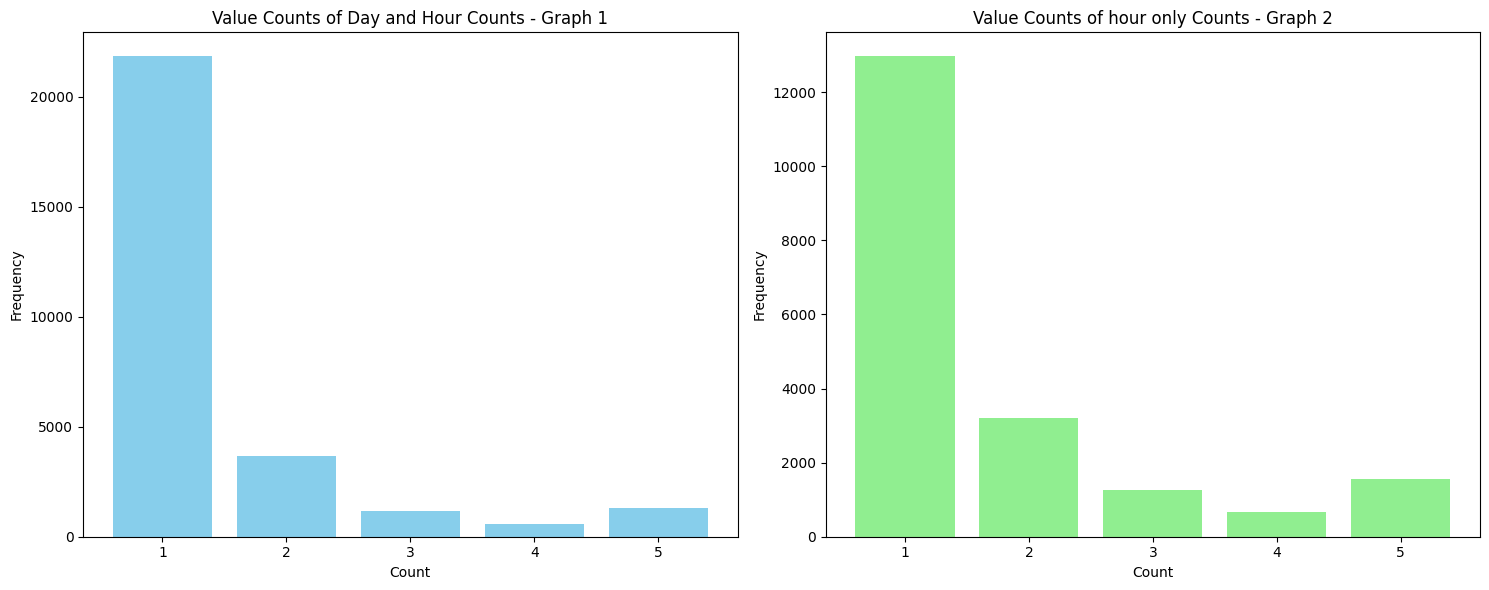

In [169]:
day_and_hour_over_0 = by_day_and_hour[by_day_and_hour['Count'] > 0]['Count'].value_counts()
hour_only_over_0 = by_hour_only[by_hour_only['Count'] > 0]['Count'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first graph
axes[0].bar(day_and_hour_over_0.index, day_and_hour_over_0.values, color='skyblue')
axes[0].set_title('Value Counts of Day and Hour Counts - Graph 1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(day_and_hour_over_0.index)

# Plot the second graph
axes[1].bar(hour_only_over_0.index, hour_only_over_0.values, color='lightgreen')
axes[1].set_title('Value Counts of hour only Counts - Graph 2')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(hour_only_over_0.index)

# Display the plots
plt.tight_layout()
plt.show()

In [170]:
by_hour_only_csv = f"output/noise-complaints-by-hour.csv"
by_hour_only.to_csv(by_hour_only_csv, index=False)
print(f"Complaints saved: {by_hour_only_csv}")

Complaints saved: output/noise-complaints-by-hour.csv


In [171]:
by_day_and_hour_csv = f"output/noise-complaints-by-day-and-hour.csv"
by_day_and_hour.to_csv(by_day_and_hour_csv, index=False)
print(f"Complaints saved: {by_day_and_hour_csv}")

Complaints saved: output/noise-complaints-by-day-and-hour.csv


## Try some models
We now have two datasets to play with - one is by day and hour, the other is just by hour. They both are clipped from 0 - 5.

In [9]:
df_hourly = pd.read_csv("output/noise-complaints-by-hour.csv")
df_day_and_hourly = pd.read_csv("output/noise-complaints-by-day-and-hour.csv")

In [10]:
df_hourly = df_hourly[df_hourly.SegmentId != "000000n"]
df_day_and_hourly = df_day_and_hourly[df_day_and_hourly.SegmentId != "000000n"]

#### First do a model including all the 0s

In [11]:
# make all categories
df_hourly['SegmentId'] = df_hourly['SegmentId'].astype('category')
df_hourly['Hour'] = df_hourly['Hour'].astype('category')
df_hourly['Count'] = df_hourly['Count'].astype('category')
df_day_and_hourly['SegmentId'] = df_day_and_hourly['SegmentId'].astype('category')
df_day_and_hourly['Hour'] = df_day_and_hourly['Hour'].astype('category')
df_day_and_hourly['DayOfWeek'] = df_day_and_hourly['DayOfWeek'].astype('category')
df_day_and_hourly['Count'] = df_day_and_hourly['Count'].astype('category')

In [12]:
def train_rf_model(df, features):
    X = df[features]
    y = df['Count']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    accuracies = cross_val_score(rf, X_train, y_train, cv=5)
    model_rf = rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",rf.score(X_test,y_test))
    return model_rf

In [13]:
hourly_model = train_rf_model(df_hourly, ['Hour', 'SegmentId'])
day_and_hourly_model = train_rf_model(df_day_and_hourly, ['Hour', 'DayOfWeek', 'SegmentId'])

Random Forest MSE: 1.0328834822277133
Train Score: 0.7467105852485998
Test Score: 0.7465944370525248
Random Forest MSE: 0.16419565355128937
Train Score: 0.9427699482242525
Test Score: 0.9429313637639051


In [14]:
# Serialize the trained model into a file called model.pkl
with open(f'hourly-model.pkl', 'wb') as handle:
    pickle.dump(hourly_model, handle, pickle.HIGHEST_PROTOCOL)
# Serialize the trained model into a file called model.pkl
with open(f'day_and_hourly-model.pkl', 'wb') as handle:
    pickle.dump(day_and_hourly_model, handle, pickle.HIGHEST_PROTOCOL)

# Ok now lets try to do some more predictions on actual segments

In [15]:
# Day and hourly
all_segment_ids = df_day_and_hourly['SegmentId'].unique()
test_pred_df = pd.DataFrame.from_dict({'Hour': [0] * all_segment_ids.size, 'DayOfWeek': [2] * all_segment_ids.size, 'SegmentId': all_segment_ids })
res = day_and_hourly_model.predict(test_pred_df)
test_pred_df['Predicted'] = res
test_pred_df['Predicted'].value_counts()

Predicted
0    4980
1     207
2      50
5      11
3      10
4       3
Name: count, dtype: int64

In [16]:
# Hourly only
all_segment_ids = df_hourly['SegmentId'].unique()
test_pred_df = pd.DataFrame.from_dict({'Hour': [0] * all_segment_ids.size, 'SegmentId': all_segment_ids })
res = hourly_model.predict(test_pred_df)
test_pred_df['Predicted'] = res
test_pred_df['Predicted'].value_counts()

Predicted
0    3674
1     879
2     281
5     209
3     149
4      69
Name: count, dtype: int64

### Final test: a full map!!!
Now let's try predicting for all possible segment ids and then mapping it

In [17]:
all_segment_ids = lion_gdf['SegmentID'].unique()

In [18]:
def map_segments(lion_gdf, df):
    lion_gdf = lion_gdf.to_crs(4326)
    df_map = pd.DataFrame()
    segment_ids = df['SegmentId'].unique()
    lats = []
    lngs = []

    # For each segment id, get a lat/lng
    for segment_id in segment_ids:
        y = lion_gdf.query(f'SegmentID == "{segment_id}"').geometry.centroid.y
        lats.append(y.values[0])
        x = lion_gdf.query(f'SegmentID == "{segment_id}"').geometry.centroid.x
        lngs.append(x.values[0])

    df_map = pd.DataFrame.from_dict({'SegmentId': segment_ids, 'Latitude': lats, 'Longitude': lngs, 'Count': df['Predicted']})
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_map, x='Longitude', y='Latitude', hue='Count', palette='viridis', legend=True)
    plt.title('Geographical Distribution of Quantity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [19]:
def make_prediction(hour, day = None):
    global all_segment_ids
    if day != None:
        test_pred_df = pd.DataFrame.from_dict({'Hour': [hour] * all_segment_ids.size, 'DayOfWeek': [day] * all_segment_ids.size, 'SegmentId': all_segment_ids })
        res = day_and_hourly_model.predict(test_pred_df)
    else:
        test_pred_df = pd.DataFrame.from_dict({'Hour': [hour] * all_segment_ids.size, 'SegmentId': all_segment_ids })
        res = hourly_model.predict(test_pred_df)
    test_pred_df['Predicted'] = res
    return test_pred_df

In [24]:
# Busy hours
prediction_1 = make_prediction(1, 1)
prediction_2 = make_prediction(1)

# Quiet hours
prediction_3 = make_prediction(5, 2)
prediction_4 = make_prediction(5)

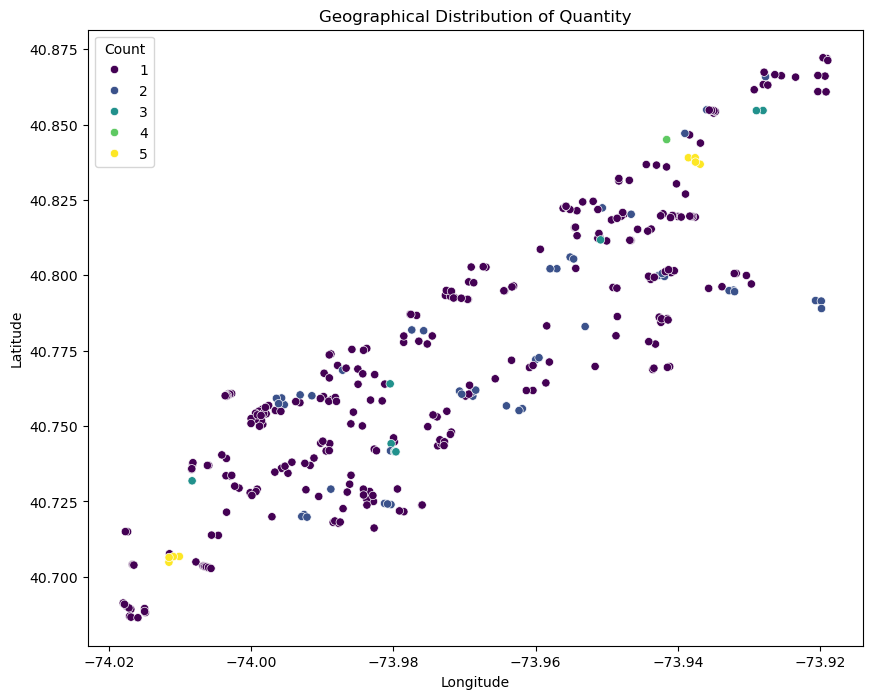

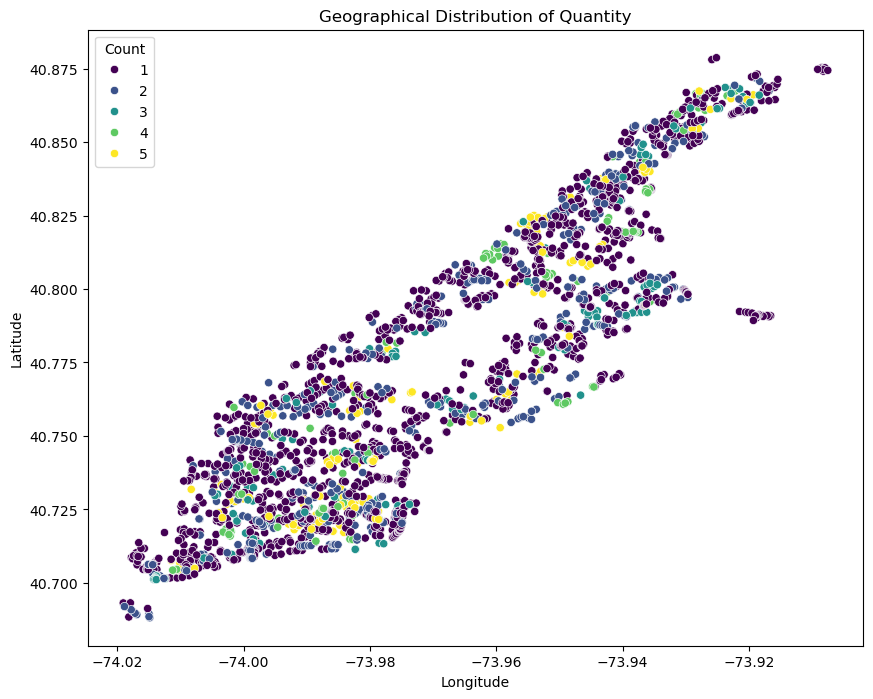

In [26]:
# Save time by only mapping greater than 0
map_df = prediction_1[prediction_1['Predicted'] > 0]
map_segments(lion_gdf, map_df)
map_df = prediction_2[prediction_2['Predicted'] > 0]
map_segments(lion_gdf, map_df)

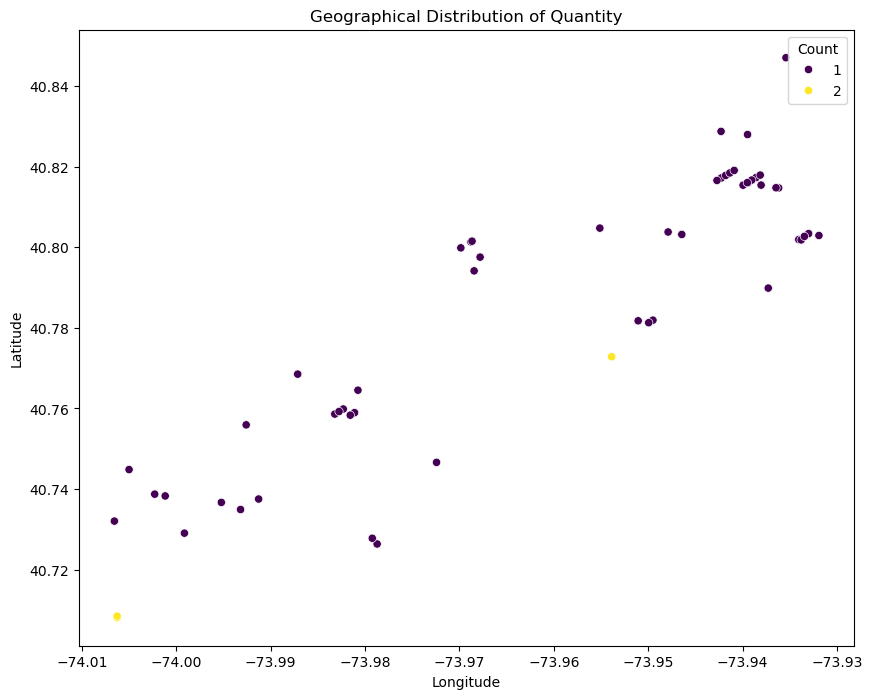

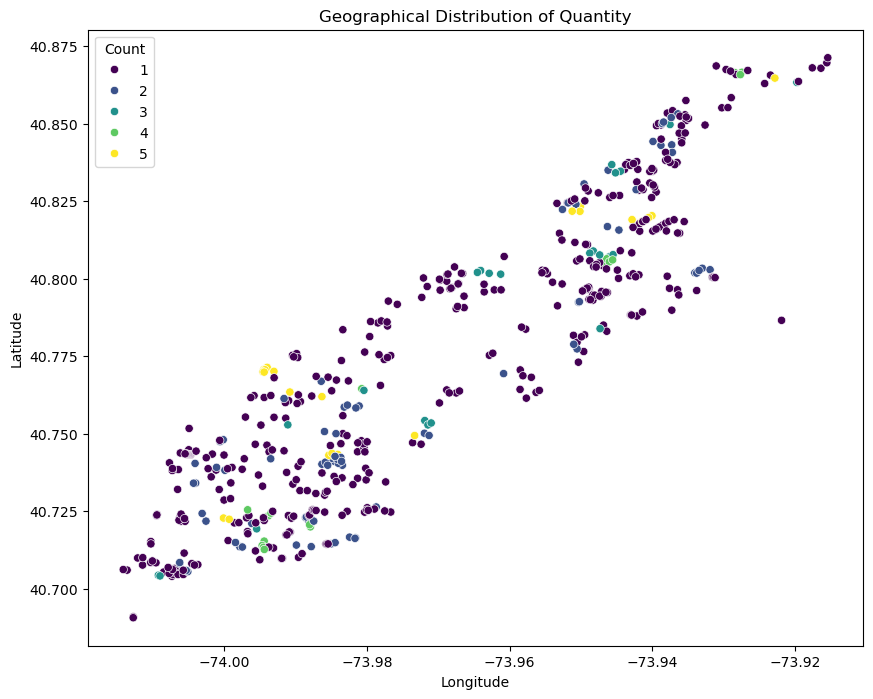

In [27]:
# Save time by only mapping greater than 0
map_df = prediction_3[prediction_3['Predicted'] > 0]
map_segments(lion_gdf, map_df)
# Save time by only mapping greater than 0
map_df = prediction_4[prediction_4['Predicted'] > 0]
map_segments(lion_gdf, map_df)

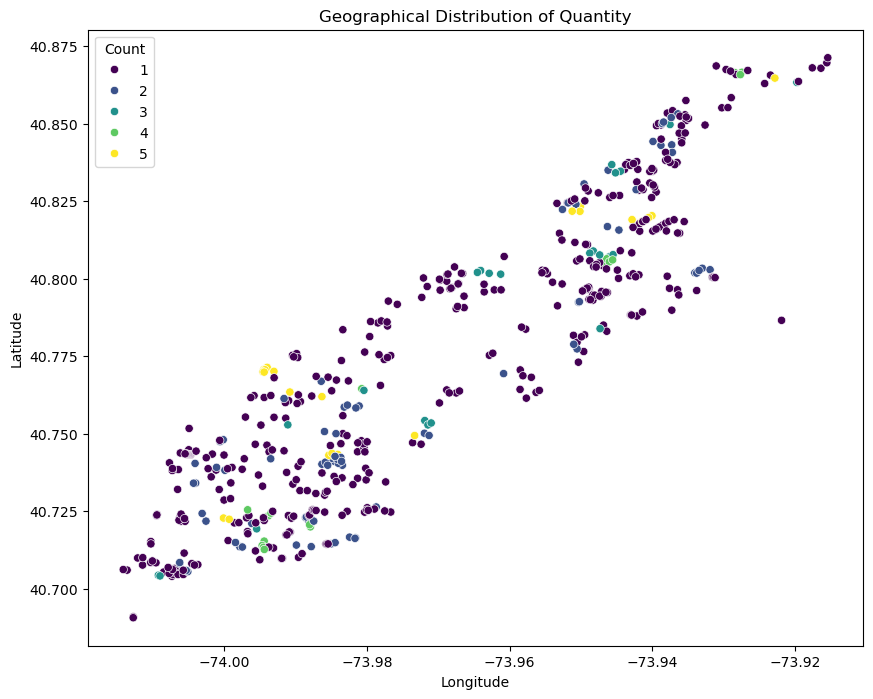

In [23]:
# Try a generally quiet time
prediction_3 = make_prediction(5)
map_df = prediction_3[prediction_3['Predicted'] > 0]
map_segments(lion_gdf, map_df)